# Assignment

Do [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) on the famous [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). For extra points explore the effect of [L1/L2 regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)).

# Setup
The topics of this exercise are very famous and very well known, so a lot of educational material is available online:

* [Logistic regression @towardsdatascience](https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102)
* [Logistic regression @Biochemia Medica](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936971/)
* [Logistic regression @datacamp](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)

Let's just frame the terms of the problem:
* we are talking about **binary** classification: all your samples belong to two classes (called 0 and 1). You want to build a statistical machine able to predict, for a new sample, the class
* for each sample we have a set numbers, called **features**. The easiest case is when these features are actual phyisical measurements, but any set of data will do
* in standard regression we weight each feature with a number (positive or negative, big or small). We then multiply each feature times its weight and add everything...
* ...but we cannot do that, since the resulting number could be very big (positive or negative big). Our desided result is a class. In other words our machine need to produce either a zero or a one. Or maybe **all the numbers between zero and one**, so that we have an idea about how certain our prediction is
* in fact, a 0.99 will show more confidence than a 0.8, which will be more confident than a 0.65
* to do so we feed what is produced by a regular regression into a sigmoid function, which looks like this: 

![logistic](../data/Logistic-curve.png "logistic")

This function takes in input any number from -infinity to +infinity and returns a value between zero and one. This will be our prediction. Let's start building the solution.

## Setting the random seed

First of all, we setup the random seed to ensure reproducibility of results.

In [1]:
import random
random.seed(99)

# The Iris dataset

The dataset we are going to use is very famous. It was published by Robert Fisher in 1936 together with the paper [The use of multiple measurements in taxonomic problems](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-1809.1936.tb02137.x). Data are public and nowadays this dataset is shipped with many statistical software and packages. We are going to use the one coming with [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris)

In [5]:
import sklearn.datasets
iris = sklearn.datasets.load_iris(return_X_y = False, as_frame = True)

The variable `iris` is now a [bunch object](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch) and contains all the required data.

In [3]:
#uncomment the following instruction to print a detailed description
#of the Iris dataset, here omitted for compactness
#print(iris.DESCR)

The dataset describes 150 flower samples, belonging to three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Features are found in the attribute `.data` of the returned bunch object:

In [9]:
print('Shape of the feature table: ' + str(iris.data.shape))

Shape of the feature table: (150, 4)


We can take a look at the actual numbers:

In [10]:
print(iris.data)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


As said above, each of the 150 lines represents a different flower, each belonging to one of the three Iris species. This will be our target, the class that we are trying to predict. Let's take a look into the dataset:

In [13]:
print('Shape of the target variable: ' + str(iris.target.shape))
print('Names for each class: ' + str(iris.target_names))

#using Counter object to print a tally of the classes
from collections import Counter
print('Numerosity for each class: ' + str(Counter(iris.target)))

Shape of the target variable: (150,)
Names for each class: ['setosa' 'versicolor' 'virginica']
Numerosity for each class: Counter({0: 50, 1: 50, 2: 50})


Always when working with a new dataset is importat to plot the data if possible. We are unfortunately talking about a 5-dimensional dataset: the four features + the target class, which is not easily representable. One solution in these cases is to slice a subset of the whole dataset.

In the following code we'll plot two features at a time, plus the class.

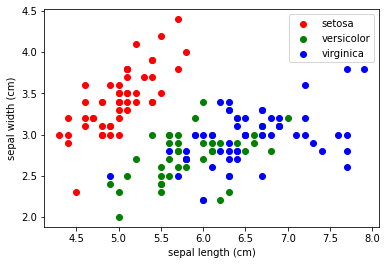

In [14]:
#change these two values to plot different features, remembering the numbering:
# 0 : sepal length (cm)
# 1 : sepal width (cm)
# 2 : petal length (cm)
# 3 : petal width (cm)
feature_x = 0
feature_y = 1

#old reliable pyplot!
import matplotlib.pyplot as plt

#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=iris.data.iloc[0:50,feature_x],    y=iris.data.iloc[0:50,feature_y],    c='red',   label=iris.target_names[0])
ax.scatter(x=iris.data.iloc[50:100,feature_x],  y=iris.data.iloc[50:100,feature_y],  c='green', label=iris.target_names[1])
ax.scatter(x=iris.data.iloc[100:150,feature_x], y=iris.data.iloc[100:150,feature_y], c='blue',  label=iris.target_names[2])

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

The plot shows clearly that setosa is quite separate from the other two classes. Even chosing other features for the plot, the general result is similar.

To be totally frank, this dataset is quite simple. In fact even if it's not possible to easily plot everything, using the four features most classifier can reach very close to 100% accuracy, especially when trying to separate Setosa from the other species.

To make things a little more interesting we decide to renounce to half of our features. Moreover, we join together Setosa and Versicolor. In other words, we want a classifier able to discriminate Virginica from the other irises:

In [17]:
#simplifly the problem: less classes, less variables
features = iris.data.iloc[:, 0:2]
target = iris.target
target[50:100] = 0 #this makes things difficult. For an easier problems set versicolor as virginica

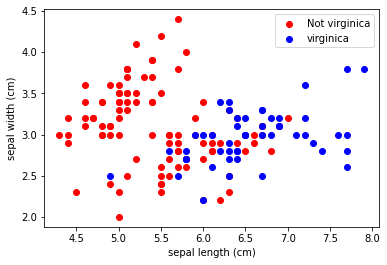

In [21]:
#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=features.iloc[0:100,0],   y=features.iloc[0:100,1],   c='red',  label='Not virginica')
ax.scatter(x=features.iloc[100:150,0], y=features.iloc[100:150,1], c='blue', label='virginica')

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

In [8]:
#selecting the first 100 samples for training would be a bad choice...
print(Counter(iris.target[0:100]))

Counter({0: 100})


In [9]:
#TRAIN/TEST SETS
#I want to have the same proportion of classes in both train and test sets

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(features, target):
    features_train = features.iloc[train_index, :]
    features_test = features.iloc[test_index, :]
    target_train = target[train_index]
    target_test = target[test_index]
    
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(120, 2)
(30, 2)
(120,)
(30,)


In [10]:
#https://www.tensorflow.org/guide/keras/train_and_evaluate
from keras.models import Sequential
from keras.layers import Dense

# 2-class logistic regression in Keras
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=features_train.shape[1]))
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
history = model.fit(features_train, target_train, epochs=10, validation_data=(features_test, target_test))

Epoch 1/10
4/4 [==============================] - 0s 35ms/step - loss: 2.1368 - val_loss: 2.1403
Epoch 2/10
4/4 [==============================] - 0s 7ms/step - loss: 2.0928 - val_loss: 2.1034
Epoch 3/10
4/4 [==============================] - 0s 6ms/step - loss: 2.0593 - val_loss: 2.0718
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 2.0302 - val_loss: 2.0431
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 2.0037 - val_loss: 2.0166
Epoch 6/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9776 - val_loss: 1.9893
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9520 - val_loss: 1.9637
Epoch 8/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9271 - val_loss: 1.9373
Epoch 9/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9021 - val_loss: 1.9119
Epoch 10/10
4/4 [==============================] - 0s 7ms/step - loss: 1.8781 - val_loss: 1.8865


In [11]:
#take a look at losses evolution
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

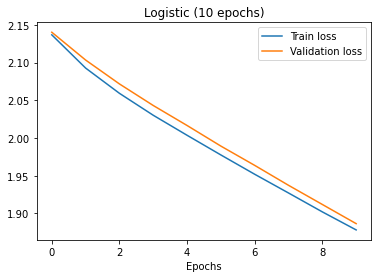

In [12]:
plot_loss_history(history, 'Logistic (10 epochs)')

In [13]:
#loss just goes down, we can keep training (whithout recompiling)
#putting verbose to 0 to avoid filling the screen
history2 = model.fit(features_train, target_train, epochs=490, 
                     validation_data=(features_test, target_test), verbose=0)

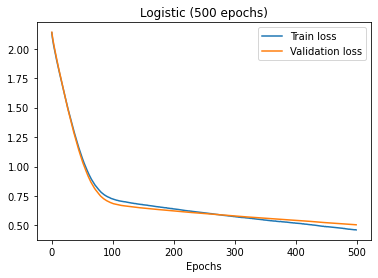

In [14]:
#putting together the whole history...
history.history['loss'] += history2.history['loss']
history.history['val_loss'] += history2.history['val_loss']

#...and plotting again!
plot_loss_history(history, 'Logistic (500 epochs)')

In [15]:
do_10000_epochs = False

In [16]:
#what happens if we keep going for a (very) long time?
if (do_10000_epochs):
    #train for 10000 epochs, just to show how the model evolves
    history3 = model.fit(features_train, target_train, epochs=9500, 
                         validation_data=(features_test, target_test), verbose=0)

    #putting together the whole history
    history.history['loss'] += history3.history['loss']
    history.history['val_loss'] += history3.history['val_loss']

    #and plotting again
    plot_loss_history(history, 'Logistic (10000 epochs)')

![regression_10000_epochs](../data/regression_loss10000.png "regression_10000_epochs")

In [17]:
if (do_10000_epochs):
    # logistic regression with L1 and L2 regularization
    from tensorflow.keras import regularizers
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', input_dim=features_train.shape[1], 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-5)))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    history_reg = model.fit(features_train, target_train, epochs=10000, 
                            validation_data=(features_test, target_test), verbose=0)
    #and plotting it
    plot_loss_history(history_reg, 'Logistic + L1L2 reg (10000 epochs)')

![regression_L1L2_10000_epochs](../data/regression_loss10000_regL1L2.png "regression_L1L2_10000_epochs")

In [18]:
if (do_10000_epochs):
    plt.plot(history.history['loss'], label = "Train loss")
    plt.plot(history_reg.history['loss'], label = "Train loss with regularization")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    plt.plot(history.history['val_loss'], label = "Validation loss")
    plt.plot(history_reg.history['val_loss'], label = "Validation loss with regularization")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

![comparison_on_train_loss](../data/comparison_train_loss.png "Comparison on train-set Loss")
![comparison_on_val_loss](../data/comparison_val_loss.png "Comparison on validation-set Loss")

In [19]:
#implement logistic regression from scratch, without keras
#https://towardsdatascience.com/a-logistic-regression-from-scratch-3824468b1f88